In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# !pip install transformers==2.11.0
# !pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.6/454.6 KB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 21.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      

In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import tensorflow as tf
import torch
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')

from tqdm import tqdm
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

BATCH_SIZE = 64
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 40

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv') 

In [4]:
train_data['label'].value_counts()

0    6516
1    6011
Name: label, dtype: int64

In [5]:
train_data['content'].nunique()

10127

In [6]:
train_data.drop_duplicates(subset=['content'], inplace=True)

In [7]:
len(train_data)

10127

<AxesSubplot:>

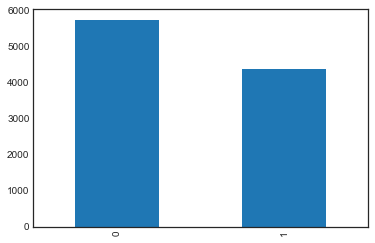

In [8]:
train_data['label'].value_counts().plot(kind='bar')

In [13]:
hate_data = pd.read_csv('data/hate_data.csv')

In [14]:
hate_data

,content,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다 2년전인가 좀 신선했었지 근데 이...,0
1,씨바알노무노무 술프노 오늘 저녁은 꽂등심이다ㅠㅜ,0
2,짱깨 꺼라ㅡ패쓰,0
3,그들의 사생활 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨소...,1
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,1
...,...,...
17891,힘내세요 응원합니다,1
17892,힘내세요삼가 고인의 명복을 빕니다,1
17893,힘내세용 항상 응원합니닷,1
17894,힘내소연기로 답해요나도 53살 인데 이런일 저런일 다 있더라구요인격을 믿습니다홨팅,1


In [22]:
hate_data.drop_duplicates(subset=['content'], inplace=True)

In [23]:
hate_data.reset_index(drop=True)

,content,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다 2년전인가 좀 신선했었지 근데 이...,0
1,씨바알노무노무 술프노 오늘 저녁은 꽂등심이다ㅠㅜ,0
2,짱깨 꺼라ㅡ패쓰,0
3,그들의 사생활 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨소...,1
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,1
...,...,...
12980,희철이가 트와이스 사귀는거 보고 트와이스 하나 노리나 보다 ㅋㅋㅋㅋㅋㅋ,1
12981,히든싱어도 끝났다예전에 비해 가수의 레벨이 너무 떨어짐,0
12982,히잌 기저귀 찬 년들이 군대 군대 주댕이 털고 자빠졌노ㅋ,0
12983,히트작이래봐야 미사 발리 두개 정도가 다고 연기력도 그저 그런 수준으로 배우로서 명...,0


In [15]:
train_data.isnull().sum()

content    0
label      0
dtype: int64

In [16]:
len(test_data)

5369

In [17]:
test_data['content'].nunique()

4908

In [19]:
test_data.drop_duplicates(subset=['content'], inplace=True)

In [20]:
test_data

,content,label
0,토니스타크 방탄소년단,1
1,구혜선 섹시하지 않은 젖꼭지였구나 실망,0
2,응 일베 개새끼,0
3,저런것들은 믹서기에 넣고 돌려야 함,0
4,아들 왜나오냐 ㅉㅉ 완전 등골빼먹는 캥거루족,0
...,...,...
5362,연기도 잘하고 이쁘게 나이먹는 여배우매니져역활을 아직도 어머니가하시나한성격하시는듯,1
5363,오창석 이채은 너무 잘어울려요 영원하시길 너무 비쥬얼 이뽀요 둘이 완죤 잘 어울려요 ㅎㅎ,1
5364,중부고속도로 하행 진천터널 즈음 터널 진입하면 허구헌날 막힘 시발 뒤에 화물차 따라...,0
5365,주말드라마를 기다려서 보긴 거의 처음아쉬운건 2화분량을 하루에 다 하는 거ㅜㅜㅜ 저...,1


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer(sentence, MAX_LEN) :
    encoded_dict = tokenizer.encode_plus(
        text = sentence,
        add_special_tokens = True,
        max_length = MAX_LEN,
        pad_to_max_length = True,
        return_attention_mask = True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

loading file vocab.txt from cache at bert_ckpt\models--bert-base-multilingual-cased\snapshots\fdfce55e83dbed325647a63e7e1f5de19f0382ba\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at bert_ckpt\models--bert-base-multilingual-cased\snapshots\fdfce55e83dbed325647a63e7e1f5de19f0382ba\tokenizer_config.json
loading configuration file config.json from cache at bert_ckpt\models--bert-base-multilingual-cased\snapshots\fdfce55e83dbed325647a63e7e1f5de19f0382ba\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,


In [17]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sentence, train_label in tqdm(zip(train_data['content'], train_data['label']), total=len(train_data)):
    try :
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
    except Exception as e :
        print(e)
        pass

train_content_input_ids = np.array(input_ids, dtype=int)
train_content_attention_masks = np.array(attention_masks, dtype=int)
train_content_token_type_ids = np.array(token_type_ids, dtype=int)
train_content_inputs = (train_content_input_ids, train_content_attention_masks, train_content_token_type_ids)
train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

print('Sentence: {}\nLabels: {}'.format(len(train_content_input_ids), len(train_data_labels)))

100%|██████████████████████████████████████████████████████████████████████████| 10127/10127 [00:04<00:00, 2355.52it/s]


Sentence: 10127
Labels: 10127


In [18]:
idx = 6
input_id = train_content_input_ids[idx]
attention_mask = train_content_attention_masks[idx]
token_type_id - train_content_token_type_ids[idx]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9638   8857 118732  10459   9718  21789  27023   9706  77884
  20173   9318  10739  30873  12605   9248  93200   9665  24982  21611
   9913  15184  26737 118748  11664   9331  25387   9428  34907  70146
   9904  16985 118921 119185  26737  11664  23130 118732  27023    102]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] 이 개넘의 짱개들 지네들이 바이러스 만들어 전세계 퍼트려놓고 백신 선점해서 팔아먹으려고 일본넘들 [SEP]


In [19]:
class TFBertClassifier(tf.keras.Model) :
    def __init__(self, model_name, dir_path, num_class) :
        super(TFBertClassifier, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.clssifier = tf.keras.layers.Dense(num_class,
                                              kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                              name='classifier')
    
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False) :
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.clssifier(pooled_output)
        
        return logits

In [22]:
cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                            dir_path='./bert_ckpt',
                            num_class=2)

loading configuration file config.json from cache at ./bert_ckpt\models--bert-base-multilingual-cased\snapshots\fdfce55e83dbed325647a63e7e1f5de19f0382ba\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

loading weights file tf_model.h5 from cache at ./bert_ckp

In [23]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [24]:
model_name = '/content/drive/MyDrive/세미 프로젝트/소스코드/tf2_bert_content/'

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = os.path.join(model_name, 'weight.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir) :
    print('{} Directory already exists\n'.format(checkpoint_dir))
else :
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} Directory create complete\n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=True)

history = cls_model.fit(train_content_inputs, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_split=VALID_SPLIT,
                        callbacks=[earlystop_callback, cp_callback])

print(history.history)

/content/drive/MyDrive/세미 프로젝트/소스코드/tf2_bert_content Directory create complete

Epoch 1/3
  1/127 [..............................] - ETA: 1:43:10 - loss: 0.7262 - accuracy: 0.5000

KeyboardInterrupt: 

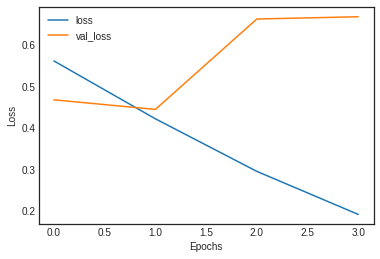

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [1]:
# BATCH_SIZE = 64
# NUM_EPOCHS = 3
# VALID_SPLIT = 0.2
# MAX_LEN = 40
# loss: 0.3461 - accuracy: 0.8559 - val_loss: 0.4716 - val_accuracy: 0.7973

# BATCH_SIZE = 32
# NUM_EPOCHS = 3
# VALID_SPLIT = 0.3
# MAX_LEN = 40
# loss: 0.2865 - accuracy: 0.8790 - val_loss: 0.4617 - val_accuracy: 0.8018

# BATCH_SIZE = 16
# NUM_EPOCHS = 3
# VALID_SPLIT = 0.3
# MAX_LEN = 40
# loss: 0.2858 - accuracy: 0.8829 - val_loss: 0.4919 - val_accuracy: 0.8010

In [37]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence, test_label in tqdm(zip(test_data['content'], test_data['label'])):
    try :
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e :
        print(e)
        pass

test_content_input_ids = np.array(input_ids, dtype=int)
test_content_attention_masks = np.array(attention_masks, dtype=int)
test_content_token_type_ids = np.array(token_type_ids, dtype=int)
test_content_inputs = (test_content_input_ids, test_content_attention_masks, test_content_token_type_ids)
test_data_labels = np.asarray(test_data_labels, dtype=np.int32)

5369it [00:01, 2913.15it/s]


In [38]:
cls_model.evaluate(test_content_inputs, test_data_labels, batch_size=512)

11/11 [==============================] - 13s 1s/step - loss: 0.6266 - accuracy: 0.7955


[0.6265504956245422, 0.7954926490783691]